In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [2]:
def extractArrays(df):
    '''Extracts feature matrix X and label array y from dataframe.'''
    return df.drop(['r_useful', 'r_id'], axis=1).values, df['r_useful'].values

In [3]:
RANDOM_SEED = 760
DATA_DIR = Path("../../ready_data")

N_OPTUNA_TRIALS = 50
N_FOLDS = 5
N_REPS = 6 # number of repetitions of CV
T_ES = 20 # threshold # consecutive non-improvement rounds for early stopping

df_train = pd.read_parquet(DATA_DIR/"100K35F_train_main.parquet.snappy")
df_val = pd.read_parquet(DATA_DIR/"100K35F_val_main.parquet.snappy")
df_test = pd.read_parquet(DATA_DIR/"100K35F_test_main.parquet.snappy")

X_train, y_train = extractArrays(df_train)
X_val, y_val = extractArrays(df_val)
X_test, y_test = extractArrays(df_test)

print(f"Shape of the training data : {X_train.shape}")
print(f"Shape of the val data : {X_val.shape}")
print(f"Shape of the test data : {X_test.shape}")

Shape of the training data : (80000, 35)
Shape of the val data : (10000, 35)
Shape of the test data : (10000, 35)


In [4]:
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))
print(X_train_val.shape)
print(y_train_val.shape)

(90000, 35)
(90000,)


In [5]:
MODEL_PREFIX = "xgb"

best_model_hp = {
    'n_estimators': 401,
    'learning_rate': 0.022600313054882564,
    'max_depth': 12,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'gamma': 0.06632386259883208
}

XGB_model = XGBRegressor(
    booster="gbtree",
    n_jobs=-1, # use all CPUs.
    tree_method="gpu_hist", # use GPU
    predictor="gpu_predictor",
    objective="reg:squarederror",
    eval_metric=["rmse"],
    random_state=RANDOM_SEED
)

# Mean imputation and standardisation
model_pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("ss", StandardScaler()),
    (MODEL_PREFIX, XGB_model)])

# needed for setting parameters correctly in pipe
def hp_appender(hp_dict):
    '''Return dictionary where every key has the MODEL_PREFIX__ appended.'''
    new_dict = {}
    for key, val in hp_dict.items():
        new_dict[MODEL_PREFIX + "__" + key] = val
    return new_dict

In [6]:
def fit_and_score(model, hps, X_train, y_train, X_test, y_test):
    model.set_params(**hp_appender(hps))
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    # calculate scores
    rmse = mean_squared_error(y_test, y_preds, squared=False)
    mae = mean_absolute_error(y_test, y_preds)
    return rmse, mae

In [7]:
rmse, mae = fit_and_score(model_pipe, best_model_hp,
    X_train_val, y_train_val, X_test, y_test)

print(f"Best overall RMSE: {rmse}")
print(f"Best overall MAE: {mae}")

Best overall RMSE: 3.0906995594281392
Best overall MAE: 1.327068233421445


XGBoost built-in importance

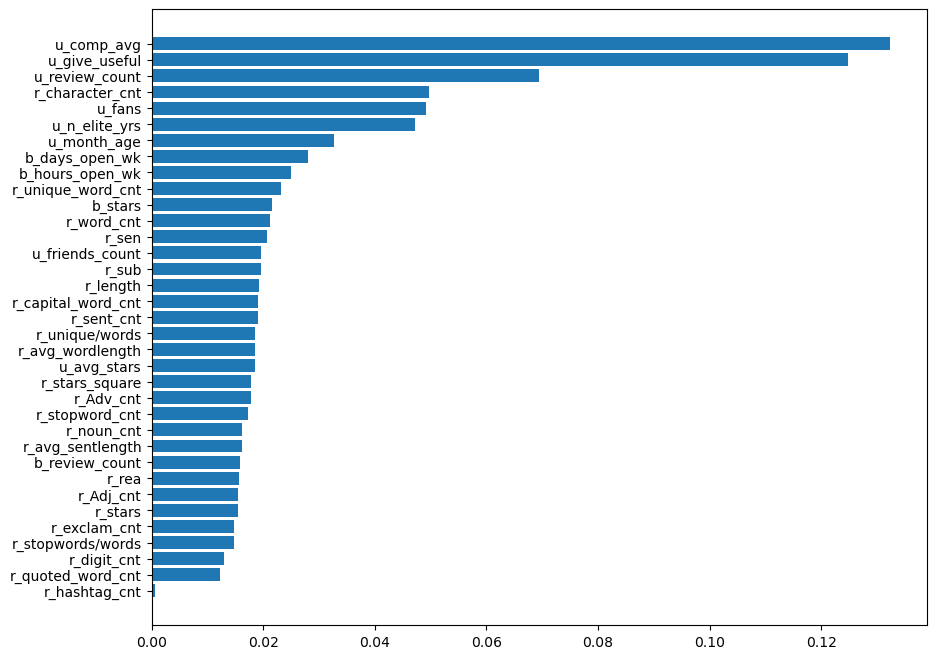

In [8]:
ii = XGB_model.feature_importances_.argsort()
plt.figure(figsize=(10, 8))
plt.barh(df_train.columns[1:-1][ii], XGB_model.feature_importances_[ii])
plt.show()

In [9]:
XGB_model.feature_importances_

array([0.01544158, 0.01777836, 0.01926767, 0.01968745, 0.06943306,
       0.03266498, 0.13227692, 0.04726334, 0.0491345 , 0.01844508,
       0.12479869, 0.02160508, 0.015838  , 0.02794435, 0.02498073,
       0.02067237, 0.01952019, 0.01563805, 0.02127573, 0.04979299,
       0.01908877, 0.02318675, 0.01724938, 0.01851027, 0.01614814,
       0.01852954, 0.01471161, 0.01296374, 0.0161983 , 0.01547757,
       0.01772627, 0.01909449, 0.0123228 , 0.0005218 , 0.01481138],
      dtype=float32)

In [10]:
df_train.columns

Index(['r_id', 'r_stars', 'r_stars_square', 'r_length', 'u_friends_count',
       'u_review_count', 'u_month_age', 'u_comp_avg', 'u_n_elite_yrs',
       'u_fans', 'u_avg_stars', 'u_give_useful', 'b_stars', 'b_review_count',
       'b_days_open_wk', 'b_hours_open_wk', 'r_sen', 'r_sub', 'r_rea',
       'r_word_cnt', 'r_character_cnt', 'r_sent_cnt', 'r_unique_word_cnt',
       'r_stopword_cnt', 'r_avg_wordlength', 'r_avg_sentlength',
       'r_unique/words', 'r_stopwords/words', 'r_digit_cnt', 'r_noun_cnt',
       'r_Adj_cnt', 'r_Adv_cnt', 'r_capital_word_cnt', 'r_quoted_word_cnt',
       'r_hashtag_cnt', 'r_exclam_cnt', 'r_useful'],
      dtype='object')